In [1]:
from PIL import Image
import numpy as np
import pandas as pd

# Import images 
full_img = Image.open('../../res/tp3/cow.jpg').convert('RGB')

sky_img = Image.open('../../res/tp3/cielo.jpg')
grass_img = Image.open('../../res/tp3/pasto.jpg')
cow_img = Image.open('../../res/tp3/vaca.jpg')


cow_pixels = list(map(lambda x: [x[0], x[1], x[2], 'cow'], cow_img.getdata()))
grass_pixels = list(map(lambda x: [x[0], x[1], x[2], 'grass'], grass_img.getdata()))
sky_pixels = list(map(lambda x: [x[0], x[1], x[2], 'sky'], sky_img.getdata()))

pixels = cow_pixels + grass_pixels + sky_pixels

df = pd.DataFrame(pixels, columns=['r', 'g', 'b', 'class'])
df.head()

,r,g,b,class
0,225,152,99,cow
1,237,164,113,cow
2,223,152,100,cow
3,206,134,84,cow
4,215,145,94,cow


In [2]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC

def get_svm(data, kernel='linear', C=1.0, verbose=False):
    X = np.array(list(map(lambda point: (point[0], point[1], point[2]), data)))
    y = list(map(lambda point: point[3], data))

    # Create a linear SVM classifier
    clf = SVC(kernel=kernel, C=C, verbose=verbose)

    # Train classifier
    clf.fit(X, y)
    
    return X, y, clf

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

train, test = train_test_split(pixels, test_size=0.2)

X, y, clf = get_svm(train, verbose=True)

[LibSVM]

In [77]:
import time

kernels = ['rbf', 'poly', 'linear']
c_values = [1.0, 10.0, 100.0, 1000.0]

img_dict = {'cow': 1, 'grass': 2, 'sky': 3}

kernel_results = {kernel: {} for kernel in kernels}

for kernel in kernels:
    for c_value in c_values:
        start = time.time()
        X_kernel, y_kernel, clf_kernel = get_svm(train, kernel=kernel, C=c_value)
        kernel_results[kernel][c_value] = (X_kernel, y_kernel, clf_kernel)
        end = time.time()
        print(f'Done with kernel {kernel} and C={int(c_value)} in {end - start} seconds')

In [76]:
# Get class value from test dataset
y_test = list(map(lambda y: y[3], test)) 


# Get predicted class value from test dataset
def eval_pred(clf):
    y_pred = list(map(lambda pixel: clf.predict([[pixel[0], pixel[1], pixel[2]]]), test))
    return y_pred

conf_mat_dict = {kernel: {} for kernel in kernels}
for kernel in kernels:
    for c_value in c_values:
        conf_mat_dict[kernel][c_value] = eval_pred(kernel_results[kernel][c_value][2])

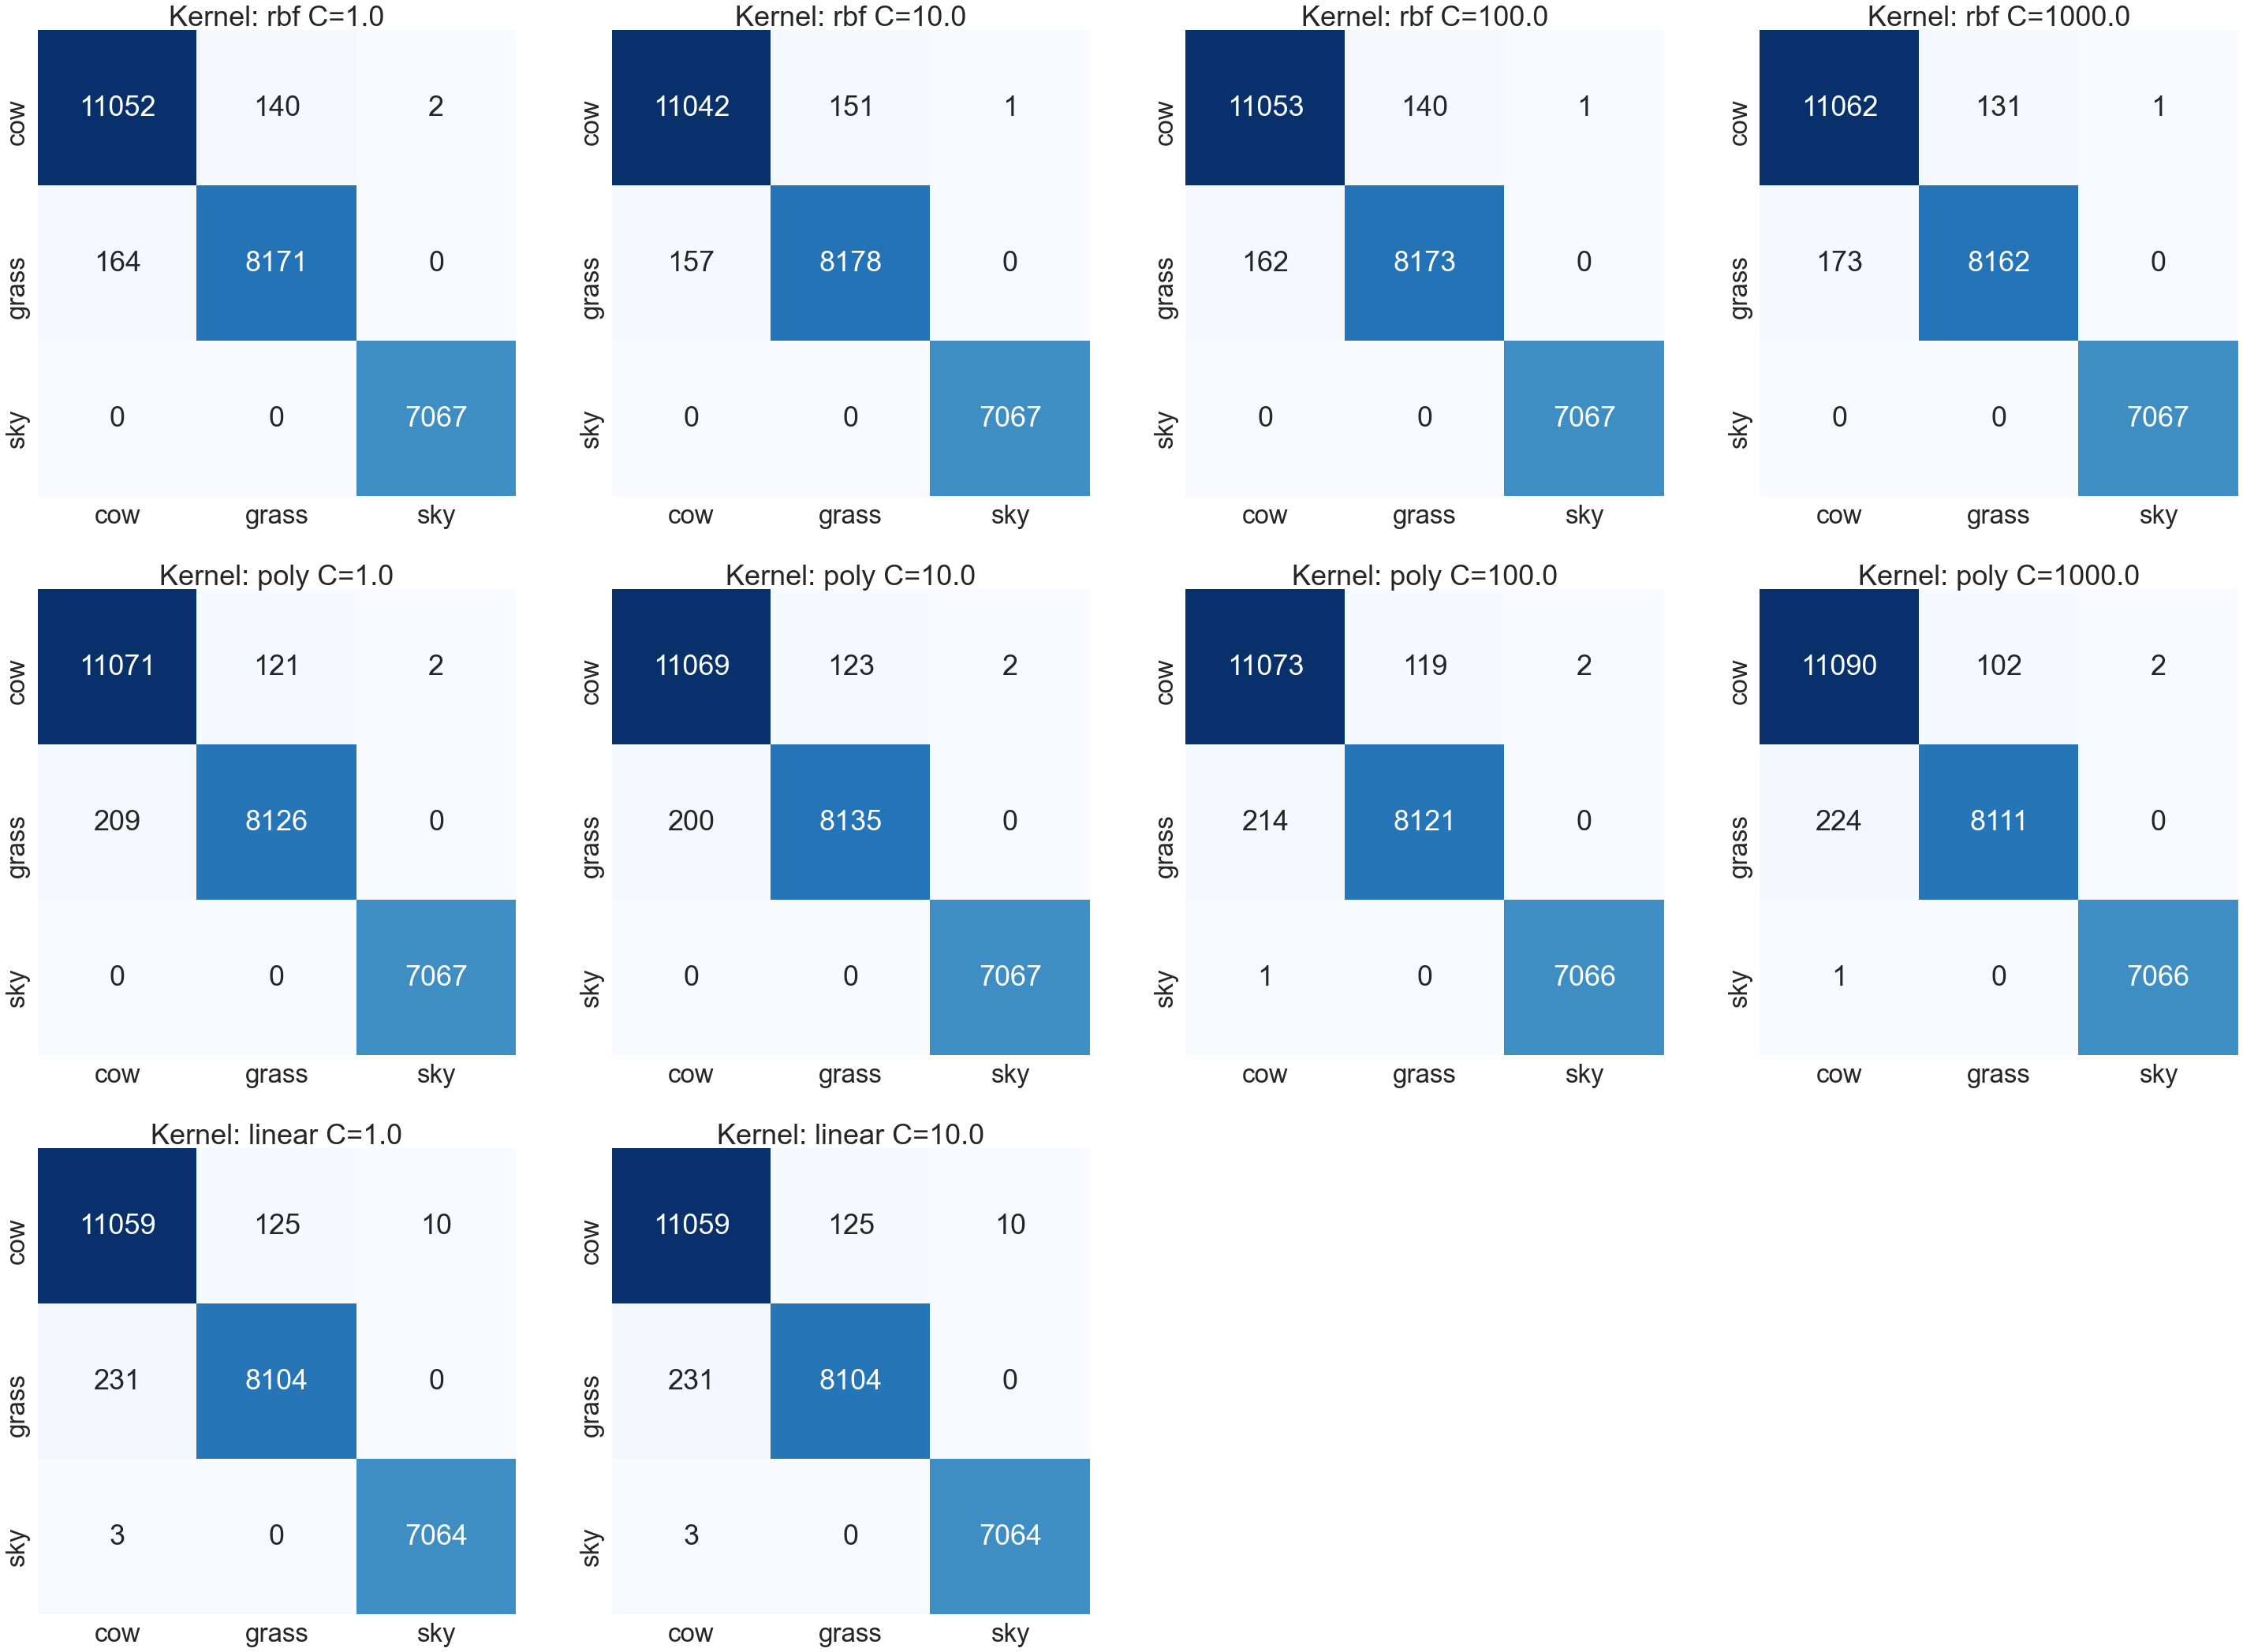

In [78]:
import seaborn as sns

sns.set(font_scale=3)

# Plot confusion matrix for classifier 

conf_mat_fig = plt.figure(figsize=(50,50))

def plot_confusion_matrix(y_pred, ax=None):
    conf_matrix = confusion_matrix(y_test, y_pred)
    count_values = list(map(lambda x: sum(x), conf_matrix))

    unique, counts = np.unique(np.array(y_test), return_counts=True)
    count_labels = dict(zip(counts, unique))

    labels = []
    for value in count_values:
        labels.append(count_labels[value])

    if ax is None:
        matrix = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False)
    else:
        matrix = sns.heatmap(conf_matrix, ax=ax, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False)

i = 4
j = 4
k = 1
for kernel in kernels:
    for c_value in c_values:
        if c_value not in conf_mat_dict[kernel]:
            continue
        mat_ax = conf_mat_fig.add_subplot(i, j, k)
        mat_ax.set_title(f'Kernel: {kernel} C={c_value}')
        mat = plot_confusion_matrix(conf_mat_dict[kernel][c_value], ax=mat_ax)
        k += 1

In [43]:
print(classification_report(y_test,conf_mat_dict['rbf'][1.0]))

              precision    recall  f1-score   support

         cow       0.99      0.99      0.99     11194
       grass       0.98      0.98      0.98      8335
         sky       1.00      1.00      1.00      7067

    accuracy                           0.99     26596
   macro avg       0.99      0.99      0.99     26596
weighted avg       0.99      0.99      0.99     26596



In [45]:
class_color_dict = {'sky': [0, 0, 255], 'grass': [0, 255, 0], 'cow': [255, 0, 0]}

def normalize_img(pixels):
    result = np.zeros(pixels.shape)
    for i in range(pixels.shape[2]):
        band = pixels[:,:,i]
        minimum = band.min()
        maximum = band.max()
        result[:,:,i] = 255 * (np.subtract(band, minimum)) / (maximum - minimum)
    
    return result


In [55]:
def classify_image(img, clf):
    full_img_pixels = np.asarray(img, dtype=np.uint8)
    class_sections_pixels = np.zeros(full_img_pixels.shape)
    for i in range(full_img_pixels.shape[0]):
        for j in range(full_img_pixels.shape[1]):
            predicted = clf.predict([full_img_pixels[i,j,:]])[0]
            class_sections_pixels[i,j,:] = class_color_dict[predicted]
    return normalize_img(full_img_pixels + class_sections_pixels)

In [79]:
result = classify_image(full_img, kernel_results['poly'][1000.0][2])

img = Image.fromarray(result.astype(np.uint8), 'RGB')
img.save('result_poly_1000.png')
img.show()

In [80]:
external_img = Image.open('../../res/tp3/atom_heart_mother.jpg').convert('RGB')
external_result = classify_image(external_img, kernel_results['poly'][1000.0][2])

img = Image.fromarray(external_result.astype(np.uint8), 'RGB')
img.save('external_result_poly_1000.png')
img.show()